# TAA Project 2 - LSTM, CNN + LDA

In [45]:
import tensorflow as tf
import pandas as pd
import string
import re
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import nltk
import spacy
import sys
from spacy.lang.en import English
import en_core_web_sm
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
import seaborn as sns

print(tf.__version__)  # 2.0.0-beta0

nltk.download('stopwords')
nltk.download('wordnet')

2.12.0


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gui\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Gui\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df = pd.read_json("dataset/Sarcasm_Headlines_Dataset_V2.json", lines=True)
df = df[['headline', 'is_sarcastic']]
df.head()

,headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1


### Exploratory Data Analysis

In [3]:
# check for columns with null values
df.is_sarcastic.isnull().any() # no missing values in is_sarcastic column
df.headline.isnull().any() # no missing values in headline column

False

In [4]:
df['headline'] = df.headline.apply(lambda x:x.lower())  # convert all words in headline into lower case 
df['headline'] = df.headline.apply(lambda x: ' '.join(word.strip(string.punctuation) for word in x.split()))  # remove all punctuations in headline

In [5]:
df['headline_count'] = df.headline.apply(lambda x: len(list(x.split())))
df['headline_unique_word_count'] = df.headline.apply(lambda x: len(set(x.split())))
df['headline_has_digits'] = df.headline.apply(lambda x: bool(re.search(r'\d', x)))
df

,headline,is_sarcastic,headline_count,headline_unique_word_count,headline_has_digits
0,thirtysomething scientists unveil doomsday clo...,1,8,8,False
1,dem rep totally nails why congress is falling ...,0,13,13,False
2,eat your veggies 9 deliciously different recipes,0,7,7,True
3,inclement weather prevents liar from getting t...,1,8,8,False
4,mother comes pretty close to using word stream...,1,9,9,False
...,...,...,...,...,...
28614,jews to celebrate rosh hashasha or something,1,7,7,False
28615,internal affairs investigator disappointed con...,1,13,12,False
28616,the most beautiful acceptance speech this week...,0,12,12,False
28617,mars probe destroyed by orbiting spielberg-gat...,1,8,8,False


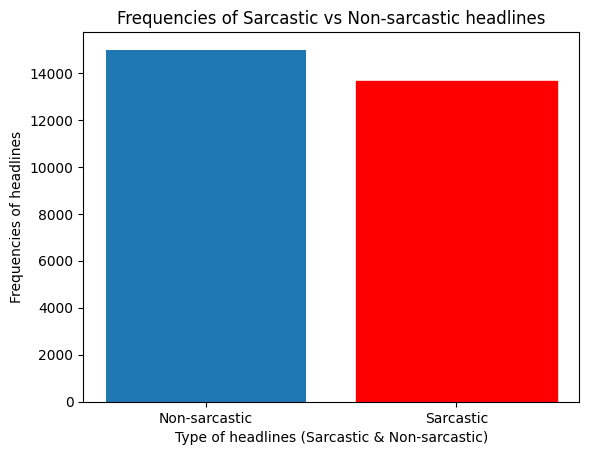

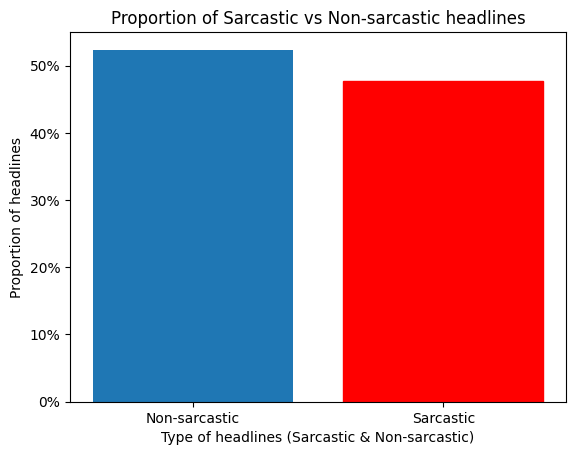

Non-sarcastic    0.52
Sarcastic        0.48
Name: headline_count, dtype: float64

In [8]:
sarcastic_dat = df.groupby('is_sarcastic').count()
sarcastic_dat.index = ['Non-sarcastic','Sarcastic']
plt.xlabel('Type of headlines (Sarcastic & Non-sarcastic)')
plt.ylabel('Frequencies of headlines')
plt.xticks(fontsize=10)
plt.title('Frequencies of Sarcastic vs Non-sarcastic headlines')
bar_graph = plt.bar(sarcastic_dat.index, sarcastic_dat.headline_count)
bar_graph[1].set_color('r')
plt.savefig("dataset_freq.png")
plt.show()


plt.xlabel('Type of headlines (Sarcastic & Non-sarcastic)')
plt.ylabel('Proportion of headlines')
plt.xticks(fontsize=10)
plt.title('Proportion of Sarcastic vs Non-sarcastic headlines')
bar_graph = plt.bar(sarcastic_dat.index, sarcastic_dat.headline_count / sarcastic_dat.headline_count.sum())
bar_graph[1].set_color('r')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.savefig("dataset_prop.png")
plt.show()

# This is not an imbalanced class dataset
# Non-sarcastic    0.56
# Sarcastic        0.44
round(sarcastic_dat.headline_count / sarcastic_dat.headline_count.sum(), 2)

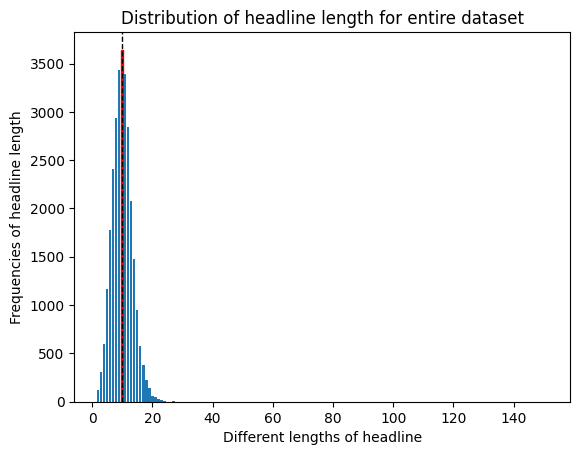

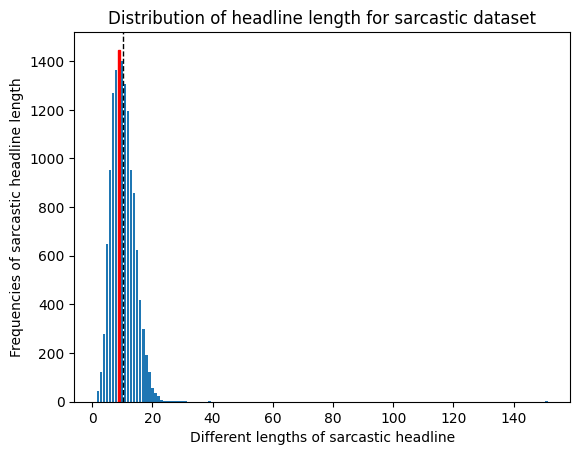

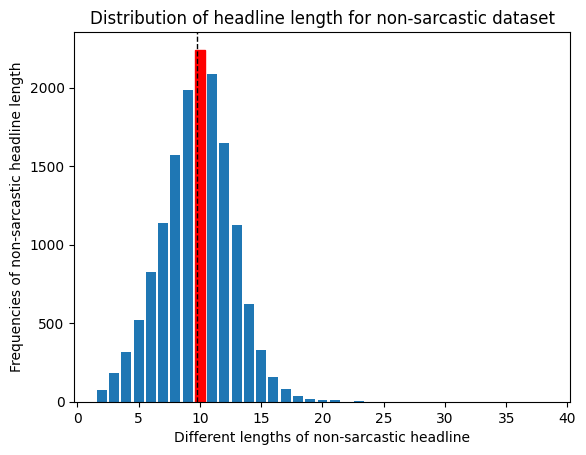

In [9]:
all_dat = df.groupby('headline_count').count()
sarcastic_dat1 = df[df.is_sarcastic==1]
sarcastic_dat = sarcastic_dat1.groupby('headline_count').count()
not_sarcastic_dat1 = df[df.is_sarcastic==0]
not_sarcastic_dat = not_sarcastic_dat1.groupby('headline_count').count()

plt.xlabel('Different lengths of headline')
plt.ylabel('Frequencies of headline length')
plt.xticks(fontsize=10)
plt.title('Distribution of headline length for entire dataset')
bar_graph = plt.bar(all_dat.index, all_dat.headline)
bar_graph[8].set_color('r')
plt.axvline(df.headline_count.mean(), color='k', linestyle='dashed', linewidth=1)  # median is 10 words in a headline
plt.savefig("dataset_headline_length.png")
plt.show()

plt.xlabel('Different lengths of sarcastic headline')
plt.ylabel('Frequencies of sarcastic headline length')
plt.xticks(fontsize=10)
plt.title('Distribution of headline length for sarcastic dataset')
bar_graph = plt.bar(sarcastic_dat.index, sarcastic_dat.headline)
bar_graph[7].set_color('r')
plt.axvline(sarcastic_dat1.headline_count.mean(), color='k', linestyle='dashed', linewidth=1)  # median is 10 words in a headline
plt.savefig("dataset_sarcastic_headline_length.png")
plt.show()


plt.xlabel('Different lengths of non-sarcastic headline')
plt.ylabel('Frequencies of non-sarcastic headline length')
plt.xticks(fontsize=10)
plt.title('Distribution of headline length for non-sarcastic dataset')
bar_graph = plt.bar(not_sarcastic_dat.index, not_sarcastic_dat.headline)
bar_graph[8].set_color('r')
plt.axvline(not_sarcastic_dat1.headline_count.mean(), color='k', linestyle='dashed', linewidth=1)  # median is 10 words in a headline
plt.savefig("dataset_non_sarcastic_headline_length.png")
plt.show()

# difference in the length of sarcastic and non-sarcastic headlines is not significant. 
# median and mean length of headlines is around 10 words

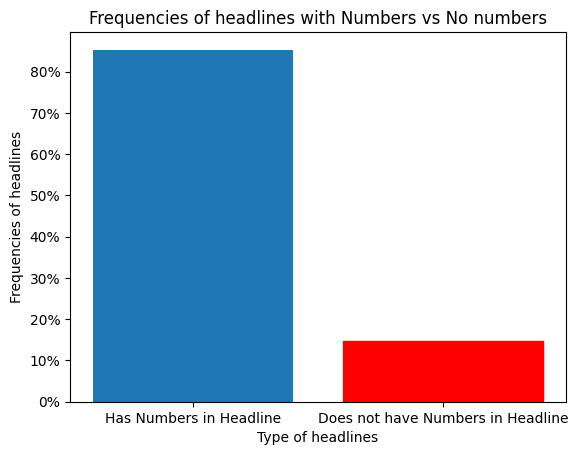

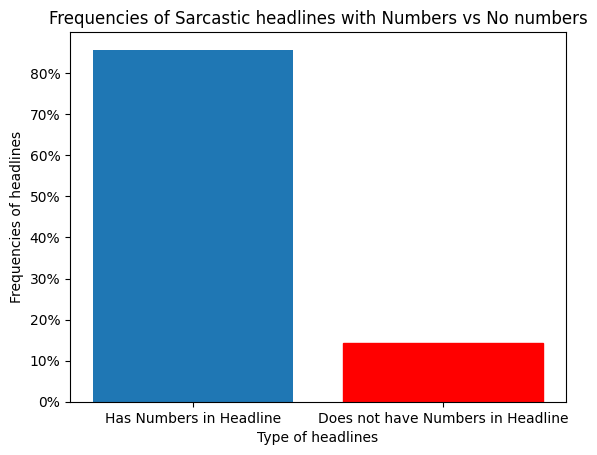

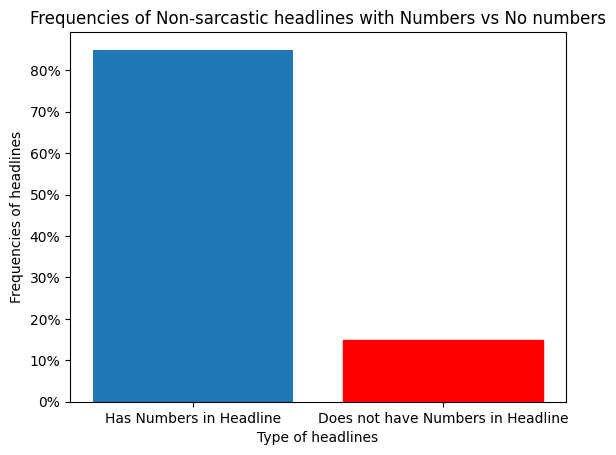

Has Numbers in Headline              0.85
Does not have Numbers in Headline    0.15
Name: headline, dtype: float64
Has Numbers in Headline              0.86
Does not have Numbers in Headline    0.14
Name: headline, dtype: float64
Has Numbers in Headline              0.85
Does not have Numbers in Headline    0.15
Name: headline, dtype: float64


In [9]:
digits_dat = df.groupby('headline_has_digits').count()
digits_dat.index = ['Has Numbers in Headline','Does not have Numbers in Headline']


plt.xlabel('Type of headlines')
plt.ylabel('Frequencies of headlines')
plt.xticks(fontsize=10)
plt.title('Frequencies of headlines with Numbers vs No numbers')
bar_graph = plt.bar(digits_dat.index, digits_dat.headline / digits_dat.headline_count.sum())
bar_graph[1].set_color('r')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()


sarcastic_digits_dat = df[df.is_sarcastic==1].groupby('headline_has_digits').count()
sarcastic_digits_dat.index = ['Has Numbers in Headline','Does not have Numbers in Headline']


plt.xlabel('Type of headlines')
plt.ylabel('Frequencies of headlines')
plt.xticks(fontsize=10)
plt.title('Frequencies of Sarcastic headlines with Numbers vs No numbers')
bar_graph = plt.bar(sarcastic_digits_dat.index, sarcastic_digits_dat.headline / sarcastic_digits_dat.headline_count.sum())
bar_graph[1].set_color('r')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()


not_sarcastic_digits_dat = df[df.is_sarcastic==0].groupby('headline_has_digits').count()
not_sarcastic_digits_dat.index = ['Has Numbers in Headline','Does not have Numbers in Headline']


plt.xlabel('Type of headlines')
plt.ylabel('Frequencies of headlines')
plt.xticks(fontsize=10)
plt.title('Frequencies of Non-sarcastic headlines with Numbers vs No numbers')
bar_graph = plt.bar(not_sarcastic_digits_dat.index, not_sarcastic_digits_dat.headline / not_sarcastic_digits_dat.headline_count.sum())
bar_graph[1].set_color('r')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show()

print(round(digits_dat.headline / digits_dat.headline_count.sum(),2))
print(round(sarcastic_digits_dat.headline / sarcastic_digits_dat.headline_count.sum(),2))
print(round(not_sarcastic_digits_dat.headline / not_sarcastic_digits_dat.headline_count.sum(),2))

# difference in the use of numbers/statistics in sarcastic and non-sarcastic headlines is not significant. 
# ~85% headlines uses numbers

### Identifying Topics in dataset via LDA

In [19]:
nlp = en_core_web_sm.load()
parser = English()
en_stop = set(nltk.corpus.stopwords.words('english'))
print(en_stop)

def tokenize(text):
    """this function is to tokenize the headline into a list of individual words"""
    lda_tokens = []
    tokens = parser(text)  # need to use parser for python to treat the list as words
    for token in tokens:
        if token.orth_.isspace():  # to ignore any whitespaces in the headline, so that token list does not contain whitespaces 
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)   # tokens (headlines) are already in lowercase
    return lda_tokens


def get_lemma(word):
    """this function is to lemmatize the words in a headline into its root form"""
    lemma = wn.morphy(word)  # converts the word into root form from wordnet
    if lemma is None:
        return word
    else:
        return lemma
    

def prepare_text_for_lda(text):
    tokens = tokenize(text)  # parse and tokenize the headline into a list of words
    tokens = [token for token in tokens if len(token) > 4]  # remove headlines with only length of 4 words or less
    tokens = [token for token in tokens if token not in en_stop]  # remove stopwords in the headline
    tokens = [get_lemma(token) for token in tokens]  # lemmatize the words in the headline
    return tokens

{'your', 'been', 'after', 'once', 'between', 'most', "didn't", "haven't", 'yourselves', "it's", 'with', 'she', 'off', 'd', 'ma', "that'll", "shouldn't", 'against', 'won', 'had', 'having', 'which', 'wouldn', 'ourselves', 'mustn', 'about', 'so', 'hers', 'being', 'under', 'into', 'few', "couldn't", 'what', 'was', 'same', 'again', 'we', 'were', "aren't", 'until', "you've", 'each', 'before', 'm', 'theirs', 'they', 'himself', 'myself', 'herself', 'more', 'or', 'and', 'his', 'y', 'only', 'for', 'is', "you're", 'be', 'while', 'to', 'that', 'aren', "hasn't", 'our', "wasn't", 'mightn', 'an', 'couldn', "won't", 'them', 'ours', 'but', 'very', "shan't", 'if', 'weren', 'hadn', 'my', 'him', "mustn't", 'shouldn', 'by', 'nor', "mightn't", 'because', 'does', 'has', 'where', 're', "weren't", 'how', "she's", "you'll", 'too', 'are', 'needn', "isn't", 'on', 'doing', 'didn', 'here', 'itself', 'in', 'whom', "don't", 'ain', 'o', "should've", 'am', 'yours', 'not', "wouldn't", 'those', 'these', 'have', 'then', '

In [20]:
text_data = []
for headline in df.headline:
    tokens = prepare_text_for_lda(headline)
    text_data.append(tokens)

In [21]:
from gensim import corpora
import pickle

dictionary = corpora.Dictionary(text_data)  # Convert all headlines into a corpus of words, with each word as a token
corpus = [dictionary.doc2bow(text) for text in text_data]  # Convert each headline (a list of words) into the bag-of-words format. (Word ID, Count of word)
pickle.dump(corpus, open('corpus.pkl', 'wb'))  
dictionary.save('dictionary.gensim')  # takes a while to run the dictionary and corpus

In [22]:
import gensim

NUM_TOPICS = [3, 5, 10]
# passes: Number of passes through the corpus during training
# alpha: priori on the distribution of the topics in each document.
# The higher the alpha, the higher the likelihood that document contains a wide range of topics, vice versa. 
# beta: priori on the distribution of the words in each topic.
# The higher the beta, the higher the likelihood that topic contains a wide range of words, vice versa.
# we do not alter / fine tune the default values of alpha and beta
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS[1], id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=5)
topics

[(0,
  '0.009*"world" + 0.007*"change" + 0.006*"employee" + 0.006*"court" + 0.006*"woman"'),
 (1,
  '0.018*"trump" + 0.013*"house" + 0.012*"white" + 0.012*"obama" + 0.010*"woman"'),
 (2,
  '0.010*"report" + 0.007*"would" + 0.005*"school" + 0.005*"child" + 0.005*"woman"'),
 (3,
  '0.006*"every" + 0.005*"years" + 0.004*"woman" + 0.004*"award" + 0.004*"marriage"'),
 (4,
  '0.040*"trump" + 0.013*"donald" + 0.010*"clinton" + 0.007*"health" + 0.007*"hillary"')]

In [24]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 3, id2word=dictionary, passes=15)
ldamodel.save('model3.gensim')
topics = ldamodel.print_topics(num_words=5)
topics

[(0,
  '0.027*"trump" + 0.010*"american" + 0.010*"donald" + 0.007*"clinton" + 0.006*"study"'),
 (1,
  '0.009*"trump" + 0.008*"house" + 0.007*"white" + 0.007*"people" + 0.006*"woman"'),
 (2,
  '0.010*"woman" + 0.005*"change" + 0.005*"report" + 0.005*"would" + 0.005*"really"')]

In [25]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 10, id2word=dictionary, passes=15)
ldamodel.save('model10.gensim')
topics = ldamodel.print_topics(num_words=5)
topics

[(0,
  '0.013*"employee" + 0.013*"getting" + 0.010*"around" + 0.009*"office" + 0.009*"black"'),
 (1,
  '0.023*"clinton" + 0.021*"trump" + 0.015*"hillary" + 0.013*"really" + 0.011*"movie"'),
 (2,
  '0.022*"report" + 0.020*"school" + 0.018*"study" + 0.015*"find" + 0.013*"health"'),
 (3,
  '0.018*"parent" + 0.013*"child" + 0.011*"night" + 0.011*"better" + 0.009*"celebrate"'),
 (4,
  '0.017*"president" + 0.017*"state" + 0.012*"obama" + 0.011*"million" + 0.010*"try"'),
 (5,
  '0.014*"couple" + 0.013*"america" + 0.013*"want" + 0.013*"photo" + 0.012*"thing"'),
 (6,
  '0.017*"people" + 0.012*"government" + 0.012*"woman" + 0.011*"force" + 0.009*"actually"'),
 (7,
  '0.014*"court" + 0.012*"family" + 0.010*"national" + 0.009*"supreme" + 0.009*"love"'),
 (8,
  '0.091*"trump" + 0.029*"donald" + 0.024*"house" + 0.023*"white" + 0.016*"change"'),
 (9,
  '0.011*"local" + 0.011*"woman" + 0.010*"death" + 0.010*"season" + 0.009*"power"')]

In [26]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

c:\Users\Gui\OneDrive\Universidade\3o Ano - UA\2o Semestre\Tópicos de Aprendizagem Automática\Projetos\Projeto 2\taa-projeto-2\venv\lib\site-packages\pandas\core\dtypes\cast.py:1429: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [27]:
lda3 = gensim.models.ldamodel.LdaModel.load('model3.gensim')
lda_display3 = pyLDAvis.gensim.prepare(lda3, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display3)

c:\Users\Gui\OneDrive\Universidade\3o Ano - UA\2o Semestre\Tópicos de Aprendizagem Automática\Projetos\Projeto 2\taa-projeto-2\venv\lib\site-packages\pandas\core\dtypes\cast.py:1429: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [28]:
lda10 = gensim.models.ldamodel.LdaModel.load('model10.gensim')
lda_display10 = pyLDAvis.gensim.prepare(lda10, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display10)

c:\Users\Gui\OneDrive\Universidade\3o Ano - UA\2o Semestre\Tópicos de Aprendizagem Automática\Projetos\Projeto 2\taa-projeto-2\venv\lib\site-packages\pandas\core\dtypes\cast.py:1429: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [29]:
from numpy import mean

sarcastic = list(df.is_sarcastic == 1)
tuple_list = []
for headline in sarcastic:
    sarcastic = lda10[corpus[headline]]
    for tuple_ in sarcastic:
        tuple_list.append(tuple_)

print('For LDA model with 10 clusters:')
print('\nFor Sarcastic Dataset:')
print([(uk, mean([vv for kk,vv in tuple_list if kk==uk])) for uk in set([k for k,v in tuple_list])])

not_sarcastic = list(df.is_sarcastic == 0)
tuple_list = []
for headline in not_sarcastic:
    not_sarcastic = lda10[corpus[headline]]
    for tuple_ in not_sarcastic:
        tuple_list.append(tuple_)
        

print('\nFor Non-sarcastic Dataset:')
print([(uk, mean([vv for kk,vv in tuple_list if kk==uk])) for uk in set([k for k,v in tuple_list])])

# LDA model with 10 clusters not differentiable between sarcastic and not sarcastic headlines.
# Not very interpretable

For LDA model with 10 clusters:

For Sarcastic Dataset:
[(0, 0.068658315), (1, 0.015733423), (2, 0.16648777), (3, 0.015736831), (4, 0.06866164), (5, 0.015733331), (6, 0.12962462), (7, 0.0686635), (8, 0.015733166), (9, 0.43496743)]

For Non-sarcastic Dataset:
[(0, 0.07348652), (1, 0.015317235), (2, 0.18100978), (3, 0.015320987), (4, 0.07349019), (5, 0.015317184), (6, 0.14049412), (7, 0.07349222), (8, 0.015317002), (9, 0.39675483)]


In [30]:
sarcastic = list(df.is_sarcastic == 1)
tuple_list = []
for headline in sarcastic:
    sarcastic = lda[corpus[headline]]
    for tuple_ in sarcastic:
        tuple_list.append(tuple_)

print('For LDA model with 5 clusters:')
print('For Sarcastic Dataset:')
print([(uk, mean([vv for kk,vv in tuple_list if kk==uk])) for uk in set([k for k,v in tuple_list])])

not_sarcastic = list(df.is_sarcastic == 0)
tuple_list = []
for headline in not_sarcastic:
    not_sarcastic = lda[corpus[headline]]
    for tuple_ in not_sarcastic:
        tuple_list.append(tuple_)
        

print('\nFor Non-sarcastic Dataset:')
print([(uk, mean([vv for kk,vv in tuple_list if kk==uk])) for uk in set([k for k,v in tuple_list])])

# LDA model with 5 clusters not differentiable between sarcastic and not sarcastic headlines.
# Not very interpretable

For LDA model with 5 clusters:
For Sarcastic Dataset:
[(0, 0.2070793), (1, 0.46289754), (2, 0.27269542), (3, 0.028965283), (4, 0.028362412)]

For Non-sarcastic Dataset:
[(0, 0.22418898), (1, 0.4232142), (2, 0.2963597), (3, 0.028421644), (4, 0.027815502)]


In [31]:
sarcastic = list(df.is_sarcastic == 1)
tuple_list = []
for headline in sarcastic:
    sarcastic = lda3[corpus[headline]]
    for tuple_ in sarcastic:
        tuple_list.append(tuple_)

print('For LDA model with 3 clusters:')
print('For Sarcastic Dataset:')
print([(uk, mean([vv for kk,vv in tuple_list if kk==uk])) for uk in set([k for k,v in tuple_list])])

not_sarcastic = list(df.is_sarcastic == 0)
tuple_list = []
for headline in not_sarcastic:
    not_sarcastic = lda3[corpus[headline]]
    for tuple_ in not_sarcastic:
        tuple_list.append(tuple_)
        

print('\nFor Non-sarcastic Dataset:')
print([(uk, mean([vv for kk,vv in tuple_list if kk==uk])) for uk in set([k for k,v in tuple_list])])

# LDA model with 3 clusters not differentiable between sarcastic and not sarcastic headlines.
# Not very interpretable

For LDA model with 3 clusters:
For Sarcastic Dataset:
[(0, 0.049145963), (1, 0.15168102), (2, 0.79917306)]

For Non-sarcastic Dataset:
[(0, 0.048251398), (1, 0.16106306), (2, 0.79068553)]


### Prediction via Deep Learning Methods

#### RNN with GRU

In [32]:
train_data, test_data = train_test_split(df[['headline', 'is_sarcastic']], test_size=0.1)  # randomly splitting 10% of dataset to be training dataset 

training_sentences = list(train_data['headline'])
training_labels = list(train_data['is_sarcastic'])

testing_sentences = list(test_data['headline'])
testing_labels = list(test_data['is_sarcastic'])
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [33]:
vocab_size = 10000   # limit vector of words to the top 10,000 words
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

# no lemmatization, removal of stop words and stemming of headlines as we would like to maintain the syntax, literature integrity, sequence of words in LSTM.

In [34]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [35]:
# Model Definition with BiRNN (GRU)
# with L1 Lasso Regularization, for feature selection
# Dropout, for robustness of recurrent neural networks
# Batch Normalization, to stabilize and perhaps accelerate the learning process

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               9600      
 l)                                                              
                                                                 
 dense (Dense)               (None, 100)               6500      
                                                                 
 batch_normalization (BatchN  (None, 100)              400       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1

In [36]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
403/403 [==============================] - 41s 78ms/step - loss: 0.8112 - accuracy: 0.7895 - val_loss: 0.4974 - val_accuracy: 0.8564
Epoch 2/10
403/403 [==============================] - 31s 76ms/step - loss: 0.2913 - accuracy: 0.8986 - val_loss: 0.3558 - val_accuracy: 0.8567
Epoch 3/10
403/403 [==============================] - 28s 68ms/step - loss: 0.2220 - accuracy: 0.9302 - val_loss: 0.4371 - val_accuracy: 0.8361
Epoch 4/10
403/403 [==============================] - 26s 65ms/step - loss: 0.1604 - accuracy: 0.9542 - val_loss: 0.4456 - val_accuracy: 0.8491
Epoch 5/10
403/403 [==============================] - 25s 63ms/step - loss: 0.1177 - accuracy: 0.9714 - val_loss: 0.5591 - val_accuracy: 0.8456
Epoch 6/10
403/403 [==============================] - 30s 75ms/step - loss: 0.0933 - accuracy: 0.9801 - val_loss: 0.6315 - val_accuracy: 0.8445
Epoch 7/10
403/403 [==============================] - 30s 74ms/step - loss: 0.0720 - accuracy: 0.9872 - val_loss: 0.6466 - val_accuracy:

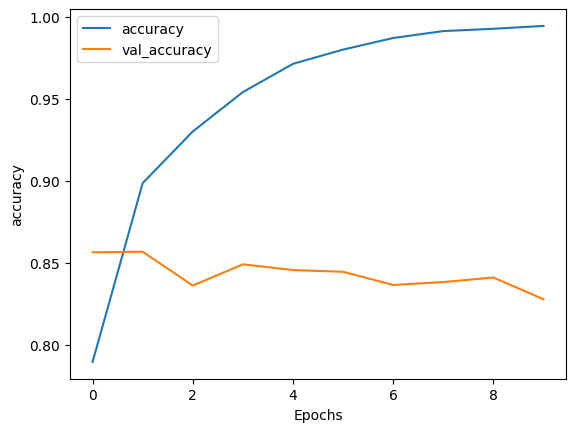

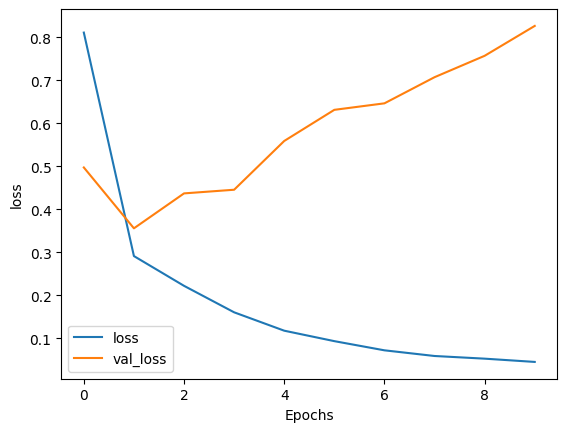

In [38]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])

plot_graphs(history, 'accuracy')
plt.savefig('RNN_GRU_L1_accuracy.png')
plt.show()
plot_graphs(history, 'loss')
plt.savefig('RNN_GRU_L1_loss.png')
plt.show()

90/90 [==============================] - 2s 20ms/step


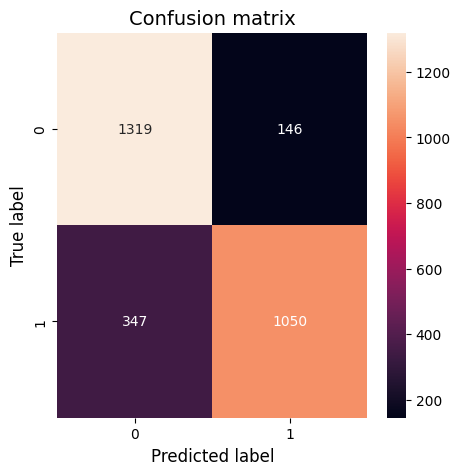

In [46]:
# Make predictions on test data
predictions = model.predict(testing_padded)
predicted_classes = np.where(predictions > 0.5, 1, 0)
true_labels = np.squeeze(testing_labels_final)

# Convert true labels to binary values
true_labels = np.where(true_labels > 0.5, 1, 0)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix", fontsize=14)
plt.ylabel('True label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.savefig('RNN_GRU_L1_confusion_matrix.png')
plt.show()

In [48]:
# Model Definition with BiRNN (GRU)
# with L2 Ridge Regularization
# Dropout, for robustness of recurrent neural networks
# Batch Normalization, to stabilize and perhaps accelerate the learning process

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               9600      
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 100)               6500      
                                                                 
 batch_normalization_2 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                

In [49]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
403/403 [==============================] - 55s 112ms/step - loss: 0.5066 - accuracy: 0.7799 - val_loss: 0.5075 - val_accuracy: 0.8075
Epoch 2/10
403/403 [==============================] - 41s 103ms/step - loss: 0.2613 - accuracy: 0.8997 - val_loss: 0.3553 - val_accuracy: 0.8456
Epoch 3/10
403/403 [==============================] - 41s 100ms/step - loss: 0.1782 - accuracy: 0.9350 - val_loss: 0.4858 - val_accuracy: 0.8152
Epoch 4/10
403/403 [==============================] - 39s 97ms/step - loss: 0.1241 - accuracy: 0.9576 - val_loss: 0.7477 - val_accuracy: 0.8047
Epoch 5/10
403/403 [==============================] - 38s 94ms/step - loss: 0.0958 - accuracy: 0.9680 - val_loss: 0.5104 - val_accuracy: 0.8428
Epoch 6/10
403/403 [==============================] - 39s 96ms/step - loss: 0.0671 - accuracy: 0.9807 - val_loss: 0.6413 - val_accuracy: 0.8407
Epoch 7/10
403/403 [==============================] - 37s 91ms/step - loss: 0.0578 - accuracy: 0.9822 - val_loss: 0.7230 - val_accura

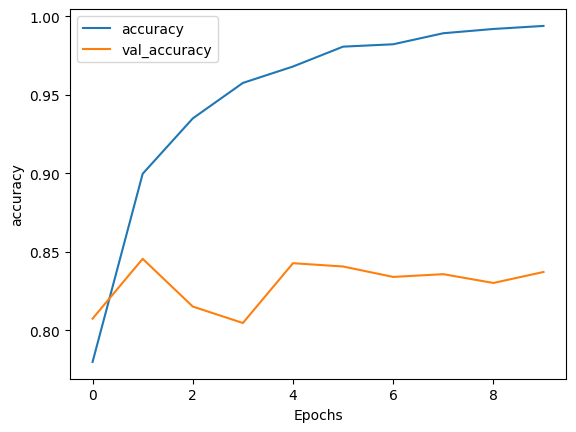

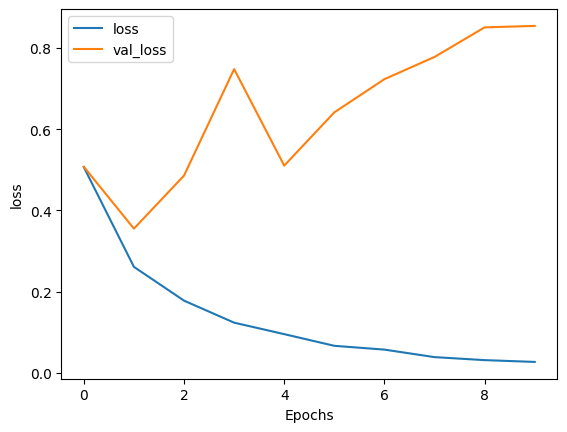

In [50]:
plot_graphs(history, 'accuracy')
plt.savefig('RNN_GRU_L2_accuracy.png')
plt.show()
plot_graphs(history, 'loss')
plt.savefig('RNN_GRU_L2_loss.png')
plt.show()

90/90 [==============================] - 4s 22ms/step


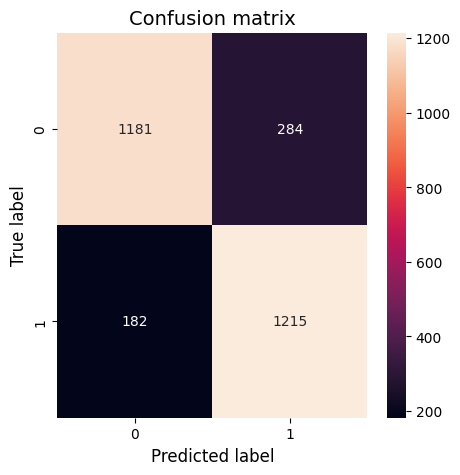

In [51]:
# Make predictions on test data
predictions = model.predict(testing_padded)
predicted_classes = np.where(predictions > 0.5, 1, 0)
true_labels = np.squeeze(testing_labels_final)

# Convert true labels to binary values
true_labels = np.where(true_labels > 0.5, 1, 0)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix", fontsize=14)
plt.ylabel('True label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.savefig('RNN_GRU_L2_confusion_matrix.png')
plt.show()

#### RNN with LSTM Architecture

In [58]:
# Model Definition with BiRNN (LSTM)
# with L1 Lasso Regularization, for feature selection
# Dropout, for robustness of recurrent neural networks
# Batch Normalization, to stabilize and perhaps accelerate the learning process

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 100)               6500      
                                                                 
 batch_normalization_5 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                

In [59]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
403/403 [==============================] - 46s 85ms/step - loss: 0.7805 - accuracy: 0.8000 - val_loss: 0.5019 - val_accuracy: 0.8463
Epoch 2/10
403/403 [==============================] - 56s 138ms/step - loss: 0.2888 - accuracy: 0.8979 - val_loss: 0.3935 - val_accuracy: 0.8389
Epoch 3/10
403/403 [==============================] - 58s 143ms/step - loss: 0.2291 - accuracy: 0.9258 - val_loss: 0.4133 - val_accuracy: 0.8480
Epoch 4/10
403/403 [==============================] - 56s 140ms/step - loss: 0.1740 - accuracy: 0.9480 - val_loss: 0.4580 - val_accuracy: 0.8452
Epoch 5/10
403/403 [==============================] - 57s 140ms/step - loss: 0.1365 - accuracy: 0.9637 - val_loss: 0.5684 - val_accuracy: 0.8459
Epoch 6/10
403/403 [==============================] - 57s 141ms/step - loss: 0.1080 - accuracy: 0.9739 - val_loss: 0.5639 - val_accuracy: 0.8477
Epoch 7/10
403/403 [==============================] - 57s 140ms/step - loss: 0.0885 - accuracy: 0.9815 - val_loss: 0.6166 - val_acc

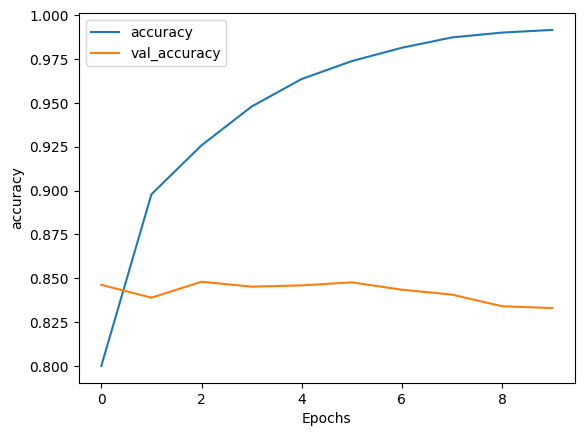

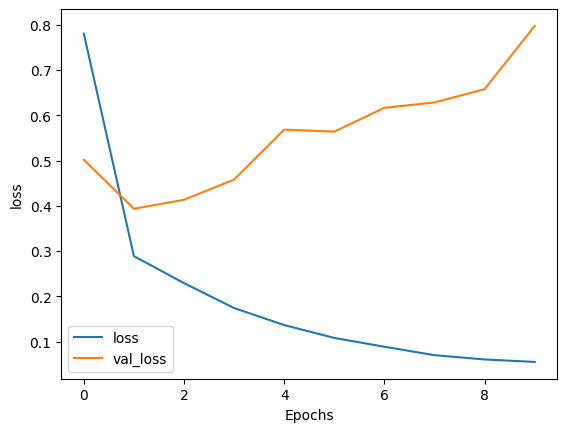

In [60]:
plot_graphs(history, 'accuracy')
plt.savefig('RNN_LSTM_L1_accuracy.png')
plt.show()
plot_graphs(history, 'loss')
plt.savefig('RNN_LSTM_L1_loss.png')
plt.show()

90/90 [==============================] - 4s 32ms/step


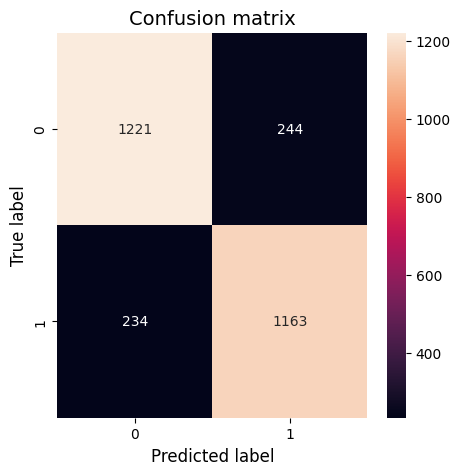

In [61]:
# Make predictions on test data
predictions = model.predict(testing_padded)
predicted_classes = np.where(predictions > 0.5, 1, 0)
true_labels = np.squeeze(testing_labels_final)

# Convert true labels to binary values
true_labels = np.where(true_labels > 0.5, 1, 0)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix", fontsize=14)
plt.ylabel('True label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.savefig('RNN_LSTM_L1_confusion_matrix.png')
plt.show()

In [62]:
# Model Definition with BiRNN (LSTM)
# with L2 Ridge Regularization
# Dropout, for robustness of recurrent neural networks
# Batch Normalization, to stabilize and perhaps accelerate the learning process

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_6 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 100)               6500      
                                                                 
 batch_normalization_6 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 100)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                

In [63]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
403/403 [==============================] - 60s 131ms/step - loss: 0.4763 - accuracy: 0.8051 - val_loss: 0.5288 - val_accuracy: 0.7250
Epoch 2/10
403/403 [==============================] - 57s 141ms/step - loss: 0.2526 - accuracy: 0.9019 - val_loss: 0.3835 - val_accuracy: 0.8438
Epoch 3/10
403/403 [==============================] - 53s 131ms/step - loss: 0.1832 - accuracy: 0.9333 - val_loss: 0.3770 - val_accuracy: 0.8578
Epoch 4/10
403/403 [==============================] - 54s 133ms/step - loss: 0.1353 - accuracy: 0.9537 - val_loss: 0.5713 - val_accuracy: 0.8075
Epoch 5/10
403/403 [==============================] - 54s 133ms/step - loss: 0.1035 - accuracy: 0.9651 - val_loss: 0.5655 - val_accuracy: 0.8197
Epoch 6/10
403/403 [==============================] - 54s 135ms/step - loss: 0.0834 - accuracy: 0.9733 - val_loss: 0.6094 - val_accuracy: 0.8351
Epoch 7/10
403/403 [==============================] - 54s 135ms/step - loss: 0.0645 - accuracy: 0.9807 - val_loss: 0.7027 - val_ac

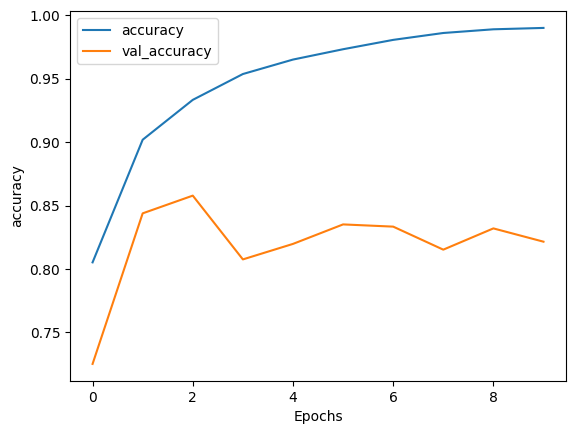

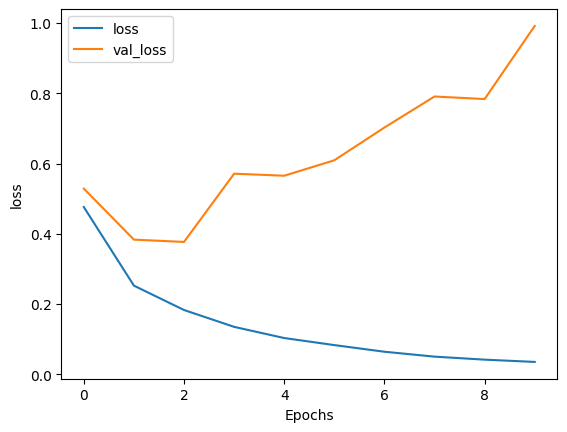

In [64]:
plot_graphs(history, 'accuracy')
plt.savefig('RNN_LSTM_L2_accuracy.png')
plt.show()
plot_graphs(history, 'loss')
plt.savefig('RNN_LSTM_L2_loss.png')
plt.show()

90/90 [==============================] - 4s 36ms/step


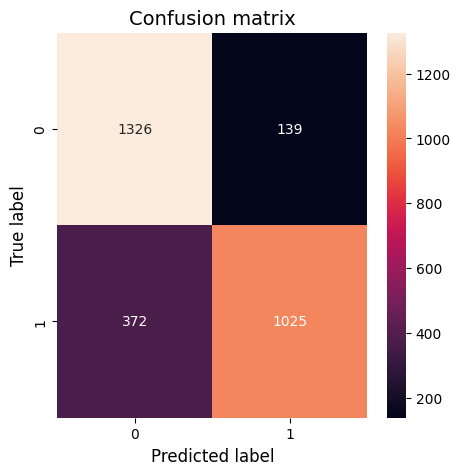

In [65]:
# Make predictions on test data
predictions = model.predict(testing_padded)
predicted_classes = np.where(predictions > 0.5, 1, 0)
true_labels = np.squeeze(testing_labels_final)

# Convert true labels to binary values
true_labels = np.where(true_labels > 0.5, 1, 0)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix", fontsize=14)
plt.ylabel('True label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.savefig('RNN_LSTM_L2_confusion_matrix.png')
plt.show()

In [66]:
# Model Definition with CNN (Conv1D)
# with L1 Lasso Regularization, for feature selection
# Dropout, for robustness
# Batch Normalization, to stabilize and perhaps accelerate the learning process

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l1(0.003), activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_14 (Dense)            (None, 100)               12900     
                                                                 
 batch_normalization_7 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dropout_7 (Dropout)         (None, 100)              

In [67]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
403/403 [==============================] - 14s 28ms/step - loss: 0.9385 - accuracy: 0.7940 - val_loss: 0.8539 - val_accuracy: 0.5210
Epoch 2/10
403/403 [==============================] - 12s 30ms/step - loss: 0.3344 - accuracy: 0.8882 - val_loss: 0.4241 - val_accuracy: 0.8351
Epoch 3/10
403/403 [==============================] - 12s 30ms/step - loss: 0.2779 - accuracy: 0.9130 - val_loss: 0.8828 - val_accuracy: 0.6747
Epoch 4/10
403/403 [==============================] - 10s 26ms/step - loss: 0.2495 - accuracy: 0.9231 - val_loss: 3.0773 - val_accuracy: 0.4941
Epoch 5/10
403/403 [==============================] - 12s 31ms/step - loss: 0.2303 - accuracy: 0.9336 - val_loss: 0.4415 - val_accuracy: 0.8333
Epoch 6/10
403/403 [==============================] - 10s 26ms/step - loss: 0.2109 - accuracy: 0.9387 - val_loss: 3.7970 - val_accuracy: 0.5339
Epoch 7/10
403/403 [==============================] - 11s 28ms/step - loss: 0.2002 - accuracy: 0.9455 - val_loss: 3.0961 - val_accuracy:

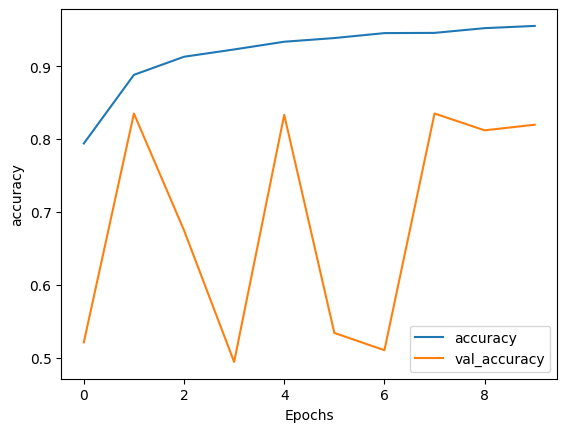

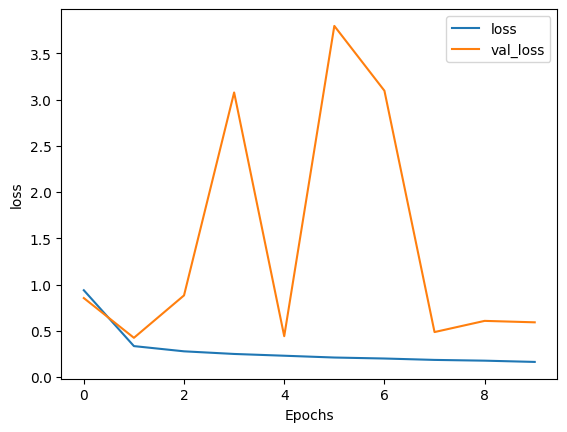

In [68]:
plot_graphs(history, 'accuracy')
plt.savefig('CNN_L1_accuracy.png')
plt.show()
plot_graphs(history, 'loss')
plt.savefig('CNN_L1_loss.png')
plt.show()

90/90 [==============================] - 1s 5ms/step


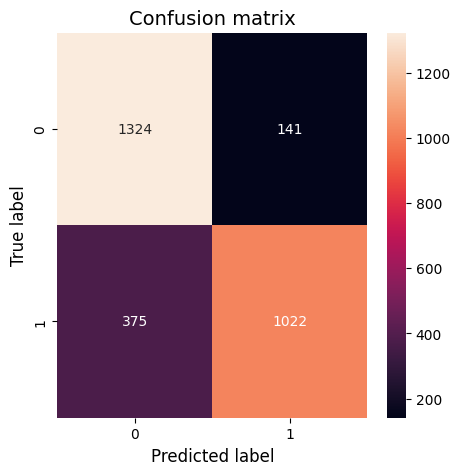

In [69]:
# Make predictions on test data
predictions = model.predict(testing_padded)
predicted_classes = np.where(predictions > 0.5, 1, 0)
true_labels = np.squeeze(testing_labels_final)

# Convert true labels to binary values
true_labels = np.where(true_labels > 0.5, 1, 0)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix", fontsize=14)
plt.ylabel('True label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.savefig('CNN_L1_confusion_matrix.png')
plt.show()

#### CNN with Conv1D

In [70]:
# Model Definition with CNN (Conv1D)
# with L2 Ridge Regularization
# Dropout, for robustness
# Batch Normalization, to stabilize and perhaps accelerate the learning process

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l2(0.003), activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d_1 (Conv1D)           (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_16 (Dense)            (None, 100)               12900     
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                 101       
                                                      

In [71]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
403/403 [==============================] - 14s 31ms/step - loss: 0.6544 - accuracy: 0.6441 - val_loss: 0.4478 - val_accuracy: 0.8106
Epoch 2/10
403/403 [==============================] - 11s 27ms/step - loss: 0.3801 - accuracy: 0.8575 - val_loss: 0.3817 - val_accuracy: 0.8442
Epoch 3/10
403/403 [==============================] - 13s 31ms/step - loss: 0.3099 - accuracy: 0.8944 - val_loss: 0.3775 - val_accuracy: 0.8480
Epoch 4/10
403/403 [==============================] - 11s 28ms/step - loss: 0.2699 - accuracy: 0.9138 - val_loss: 0.3779 - val_accuracy: 0.8466
Epoch 5/10
403/403 [==============================] - 16s 40ms/step - loss: 0.2439 - accuracy: 0.9258 - val_loss: 0.3844 - val_accuracy: 0.8470
Epoch 6/10
403/403 [==============================] - 15s 37ms/step - loss: 0.2235 - accuracy: 0.9359 - val_loss: 0.3961 - val_accuracy: 0.8480
Epoch 7/10
403/403 [==============================] - 12s 31ms/step - loss: 0.2066 - accuracy: 0.9432 - val_loss: 0.4114 - val_accuracy:

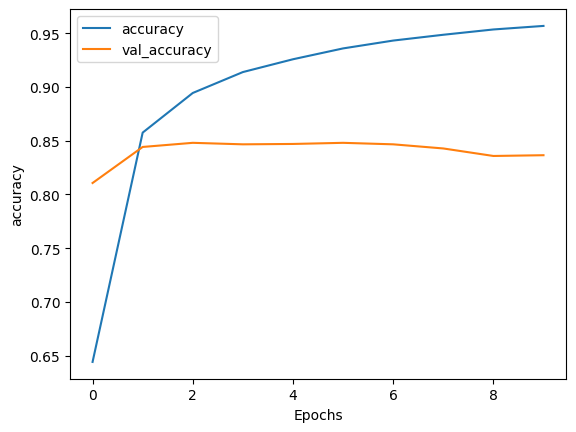

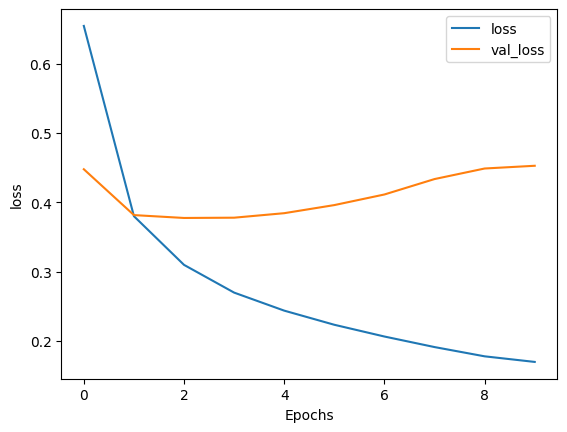

In [72]:
plot_graphs(history, 'accuracy')
plt.savefig('CNN_L2_accuracy.png')
plt.show()
plot_graphs(history, 'loss')
plt.savefig('CNN_L2_loss.png')
plt.show()

90/90 [==============================] - 1s 6ms/step


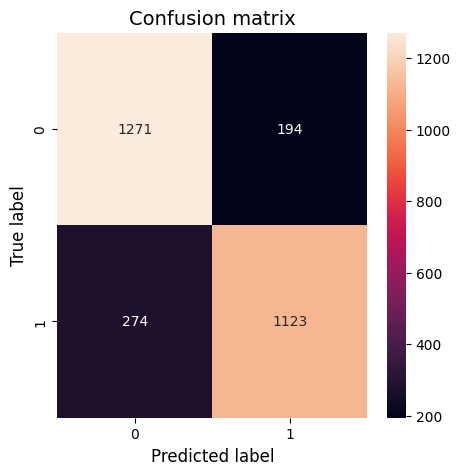

In [74]:
# Make predictions on test data
predictions = model.predict(testing_padded)
predicted_classes = np.where(predictions > 0.5, 1, 0)
true_labels = np.squeeze(testing_labels_final)

# Convert true labels to binary values
true_labels = np.where(true_labels > 0.5, 1, 0)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix", fontsize=14)
plt.ylabel('True label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.savefig('CNN_L2_confusion_matrix.png')
plt.show()

#### CNN-RNN combined architecture

In [75]:
# Model Definition with CNN (Conv1D)
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 1, activation='relu'),
    tf.keras.layers.MaxPooling1D(2, padding="same"),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(100, kernel_regularizer=tf.keras.regularizers.l1(0.005), activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, kernel_regularizer=tf.keras.regularizers.l1(0.005), activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d_2 (Conv1D)           (None, 120, 128)          2176      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 60, 128)          0         
 )                                                               
                                                                 
 bidirectional_7 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                                 
 dense_18 (Dense)            (None, 100)               6500      
                                                                 
 dropout_9 (Dropout)         (None, 100)              

In [76]:
num_epochs = 10
history = model.fit(padded, training_labels_final, epochs=num_epochs, batch_size=64, validation_data=(testing_padded, testing_labels_final))

Epoch 1/10
403/403 [==============================] - 71s 165ms/step - loss: 1.0898 - accuracy: 0.7366 - val_loss: 0.4654 - val_accuracy: 0.8484
Epoch 2/10
403/403 [==============================] - 63s 156ms/step - loss: 0.4079 - accuracy: 0.8933 - val_loss: 0.4392 - val_accuracy: 0.8564
Epoch 3/10
403/403 [==============================] - 63s 155ms/step - loss: 0.3352 - accuracy: 0.9256 - val_loss: 0.4451 - val_accuracy: 0.8546
Epoch 4/10
403/403 [==============================] - 63s 155ms/step - loss: 0.2930 - accuracy: 0.9432 - val_loss: 0.4820 - val_accuracy: 0.8512
Epoch 5/10
403/403 [==============================] - 68s 168ms/step - loss: 0.2604 - accuracy: 0.9537 - val_loss: 0.5383 - val_accuracy: 0.8459
Epoch 6/10
403/403 [==============================] - 64s 158ms/step - loss: 0.2392 - accuracy: 0.9639 - val_loss: 0.5219 - val_accuracy: 0.8470
Epoch 7/10
403/403 [==============================] - 59s 147ms/step - loss: 0.2273 - accuracy: 0.9692 - val_loss: 0.5409 - val_ac

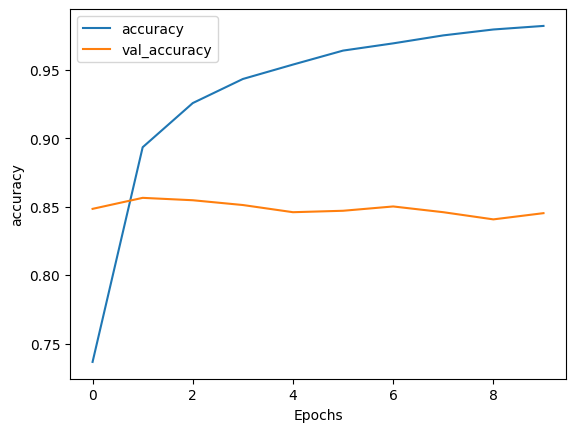

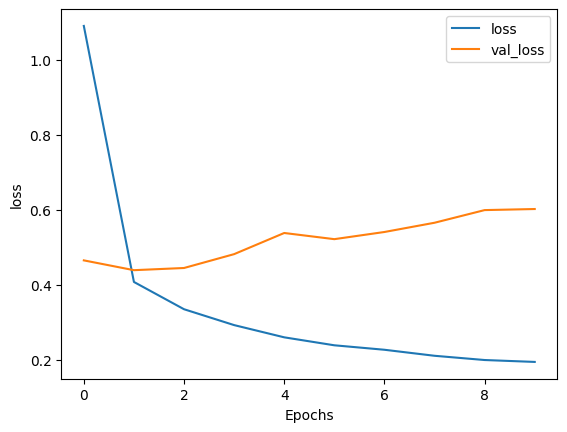

In [77]:
plot_graphs(history, 'accuracy')
plt.savefig('CNN_RNN_accuracy.png')
plt.show()
plot_graphs(history, 'loss')
plt.savefig('CNN_RNN_loss.png')
plt.show()

90/90 [==============================] - 4s 27ms/step


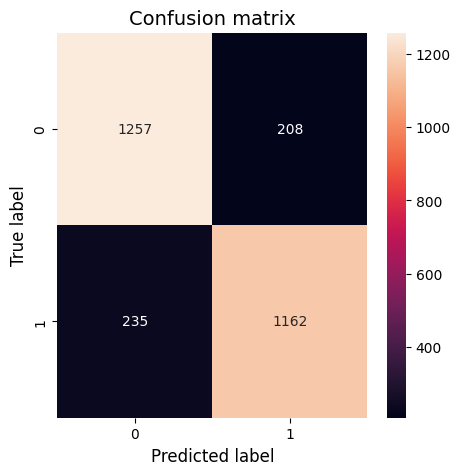

In [78]:
# Make predictions on test data
predictions = model.predict(testing_padded)
predicted_classes = np.where(predictions > 0.5, 1, 0)
true_labels = np.squeeze(testing_labels_final)

# Convert true labels to binary values
true_labels = np.where(true_labels > 0.5, 1, 0)

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix", fontsize=14)
plt.ylabel('True label', fontsize=12)
plt.xlabel('Predicted label', fontsize=12)
plt.savefig('CNN_RNN_confusion_matrix.png')
plt.show()